<a href="https://colab.research.google.com/github/AgungA1/Neuro-Detect/blob/main/Neuro_Detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data preprocessing
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from PIL import Image, ImageEnhance
from sklearn.utils import shuffle

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# For ML Models
from tensorflow.keras.applications import Xception, ResNet50, MobileNet, VGG16, VGG19
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Miscellaneous
from tqdm import tqdm
import os
import random
import pickle

# **Reading Data**

In [ ]:
def read_dataset(data_path):
    data = []

    for label in os.listdir(data_path):
        real_label = ""
        if label in ['pituitary_tumor', 'pituitary']:
            real_label = 'pituitary'
        elif label in ['no_tumor', 'notumor']:
            real_label = 'notumor'
        elif label in ['meningioma', 'meningioma_tumor']:
            real_label = 'meningioma'
        elif label in ['glioma', 'glioma_tumor']:
            real_label = 'glioma'
        for image in os.listdir(os.path.join(data_path,label)):
            data.append([os.path.join(data_path,label,image),real_label])

    return data

In [ ]:
import os

image_data_paths = "/content/drive/MyDrive/Colab Notebooks/Stupen/Brain Tumor Dataset"
train_dir = os.path.join(image_data_paths, "Training")
test_dir = os.path.join(image_data_paths, "Testing")

train_data = []
for folder in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                train_data.append([file_path, folder])

train_data = shuffle(train_data)
print(f'training image number: {len(train_data)}')

test_data = []
for folder in os.listdir(test_dir):
    folder_path = os.path.join(test_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                test_data.append([file_path, folder])

print(f'test image number: {len(test_data)}')

training image number: 5712
test image number: 1311


In [ ]:
train_data = pd.DataFrame(train_data, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
train_data.head(4)

,image_filepaths,tumor_class
0,/content/drive/MyDrive/Colab Notebooks/Stupen/...,pituitary
1,/content/drive/MyDrive/Colab Notebooks/Stupen/...,pituitary
2,/content/drive/MyDrive/Colab Notebooks/Stupen/...,pituitary
3,/content/drive/MyDrive/Colab Notebooks/Stupen/...,notumor


In [ ]:

test_data = pd.DataFrame(test_data, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
test_data.head(4)

,image_filepaths,tumor_class
0,/content/drive/MyDrive/Colab Notebooks/Stupen/...,meningioma
1,/content/drive/MyDrive/Colab Notebooks/Stupen/...,meningioma
2,/content/drive/MyDrive/Colab Notebooks/Stupen/...,notumor
3,/content/drive/MyDrive/Colab Notebooks/Stupen/...,pituitary


# **Data Visualization Distribution**

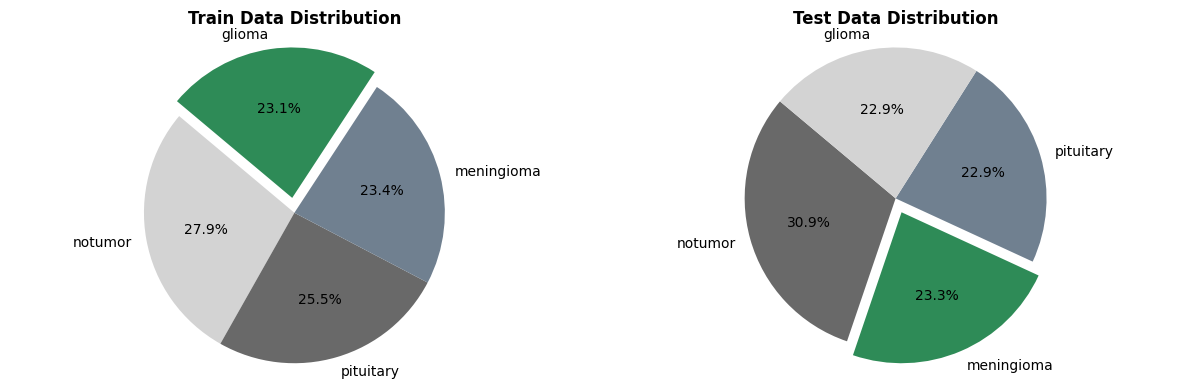

In [ ]:
def create_pie_chart(ax, data, title, colors, explode):
    ax.pie(data.values(), labels=data.keys(), autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title(title, weight='bold')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot for train_data
label_counts_train = train_data['tumor_class'].value_counts().to_dict()
total_count_train = sum(label_counts_train.values())
label_percentages_train = {label: count / total_count_train * 100 for label, count in label_counts_train.items()}
colors_train = ['lightgray', 'dimgray', 'slategrey', 'seagreen']
explode_train = (0, 0, 0, 0.1)
create_pie_chart(axes[0], label_percentages_train, 'Train Data Distribution', colors_train, explode_train)

# Plot for test_data
label_counts_test = test_data['tumor_class'].value_counts().to_dict()
total_count_test = sum(label_counts_test.values())
label_percentages_test = {label: count / total_count_test * 100 for label, count in label_counts_test.items()}
colors_test = ['dimgray', 'seagreen', 'slategrey', 'lightgray']
explode_test = (0, 0.1, 0, 0)
create_pie_chart(axes[1], label_percentages_test, 'Test Data Distribution', colors_test, explode_test)

plt.tight_layout()
plt.show()

# **Splitting Data**

In [ ]:
train_data, val_data = train_test_split(train_data,
                                               train_size = 0.85,
                                               random_state = 42,
                                               stratify = train_data.tumor_class)

In [ ]:
train_data, val_data = train_test_split(train_data,
                                               train_size = 0.85,
                                               random_state = 42,
                                               stratify = train_data.tumor_class)

In [ ]:
print(train_data.shape),
print(val_data.shape),
print(test_data.shape)

(4126, 2)
(729, 2)
(1311, 2)


# **Data Augmentation**

In [ ]:
image_size = 128
batch_size = 64

train_image_datagen_kwargs = dict(rescale = 1 / 255,
                                rotation_range = 15,
                                width_shift_range = 0.1,
                                zoom_range = 0.02,
                                shear_range = 0.01,
                                brightness_range = [0.3, 1.5],
                                horizontal_flip = True,
                                vertical_flip = True,
                                fill_mode = "nearest"
                                )

test_image_datagen_kwargs = dict(rescale = 1 / 255)

# **Image Generator**

In [ ]:
train_image_datagen = ImageDataGenerator(**train_image_datagen_kwargs) #generating batches of training data with augmentation.
val_image_datagen = ImageDataGenerator(**test_image_datagen_kwargs) #generating batches of validation data without augmentation.
test_image_datagen = ImageDataGenerator(**test_image_datagen_kwargs)#generating batches of test data without augmentation.

In [ ]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data,
                                                        x_col = 'image_filepaths',
                                                        y_col = 'tumor_class',
                                                        seed = 42,
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')

val_dataset = val_image_datagen.flow_from_dataframe(val_data,
                                                        x_col = 'image_filepaths',
                                                        y_col = 'tumor_class',
                                                        seed = 42,
                                                        shuffle=False,
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')


test_dataset = test_image_datagen.flow_from_dataframe(test_data,
                                                      x_col = 'image_filepaths',
                                                      y_col = 'tumor_class',
                                                      seed = 42,
                                                      shuffle=False,
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 4126 validated image filenames belonging to 4 classes.
Found 729 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


# **Model Development**

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 5)

In [ ]:
def model_def(base_model):

  # Set all layers to non-trainable
  for layer in base_model.layers:
      layer.trainable = False
  # Set the last block to trainable
  base_model.layers[-2].trainable = True   #unfreeze the last 3 layers
  base_model.layers[-3].trainable = True
  base_model.layers[-4].trainable = True

  # build a custom model
  model = Sequential()
  model.add(Input(shape=(image_size,image_size,3)))
  model.add(base_model) #Adds the pre-trained base model to the model.
  model.add(Flatten())  #Flattens the output
  model.add(Dropout(0.3)) # 30% chance of being dropped out, helping to reduce overfitting.
  model.add(Dense(128, activation='relu')) # Adds a fully connected layer with 128 units
  model.add(Dropout(0.2)) # Applies another dropout with a rate of 0.2.
  model.add(Dense(4, activation='softmax'))

  return model

# **VGG16 Model**

In [ ]:
model_vgg = model_def(VGG16(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                         

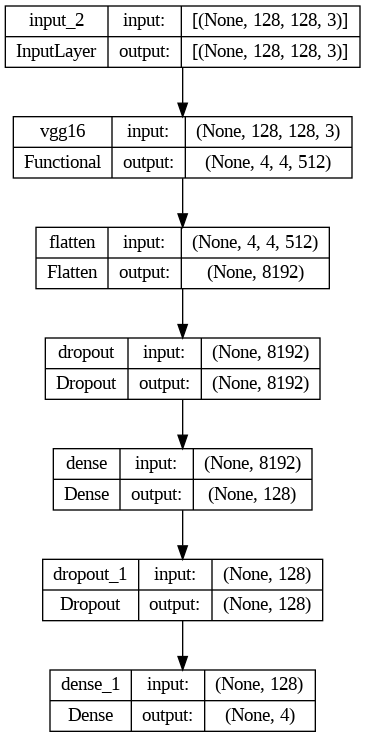

In [ ]:
keras.utils.plot_model(model_vgg, show_shapes=True)

In [ ]:
model_vgg.compile(optimizer=Adam(learning_rate=0.0005),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [ ]:
ckp_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size)) # x * epocs
ckp_folder = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/vgg"
ckp_path = os.path.join(ckp_folder,r"epocch_{epoch:02d}.hdf5")

model_vgg_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    #mode='max',
    verbose=1,
    save_freq= ckp_interval
    #save_best_only=True
)

In [ ]:
%%time
train_history_vgg = model_vgg.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 30,
                          callbacks = [early_stopping, model_vgg_checkpoint_callback])

# Save the train history
with open(os.path.join(ckp_folder,'train_history_vgg'), 'wb') as file_pi:
    pickle.dump(train_history_vgg, file_pi)


Epoch 1/30
65/65 [==============================] - 1195s 18s/step - loss: 1.0283 - categorical_accuracy: 0.5526 - val_loss: 0.6140 - val_categorical_accuracy: 0.7572
Epoch 2/30
65/65 [==============================] - 42s 645ms/step - loss: 0.6072 - categorical_accuracy: 0.7654 - val_loss: 0.4347 - val_categorical_accuracy: 0.8299
Epoch 3/30
65/65 [==============================] - 42s 646ms/step - loss: 0.4548 - categorical_accuracy: 0.8260 - val_loss: 0.3832 - val_categorical_accuracy: 0.8738
Epoch 4/30
65/65 [==============================] - 42s 654ms/step - loss: 0.3866 - categorical_accuracy: 0.8606 - val_loss: 0.3157 - val_categorical_accuracy: 0.8889
Epoch 5/30
64/65 [============================>.] - ETA: 0s - loss: 0.3544 - categorical_accuracy: 0.8732
Epoch 5: saving model to drive/MyDrive/Tumor_Classification/Model-Checkpoints/vgg/epocch_05.hdf5
65/65 [==============================] - 42s 647ms/step - loss: 0.3560 - categorical_accuracy: 0.8730 - val_loss: 0.3880 - val_ca

In [ ]:
model_vgg.save('/content/drive/MyDrive/ModelSave/VGG-16/vgg16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print(train_history_vgg.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [ ]:
# If load the history from the previsouly trained model.
with open(os.path.join(ckp_folder,'train_history_vgg'), 'rb') as file_pi:
    train_history_vgg = pickle.load(file_pi)

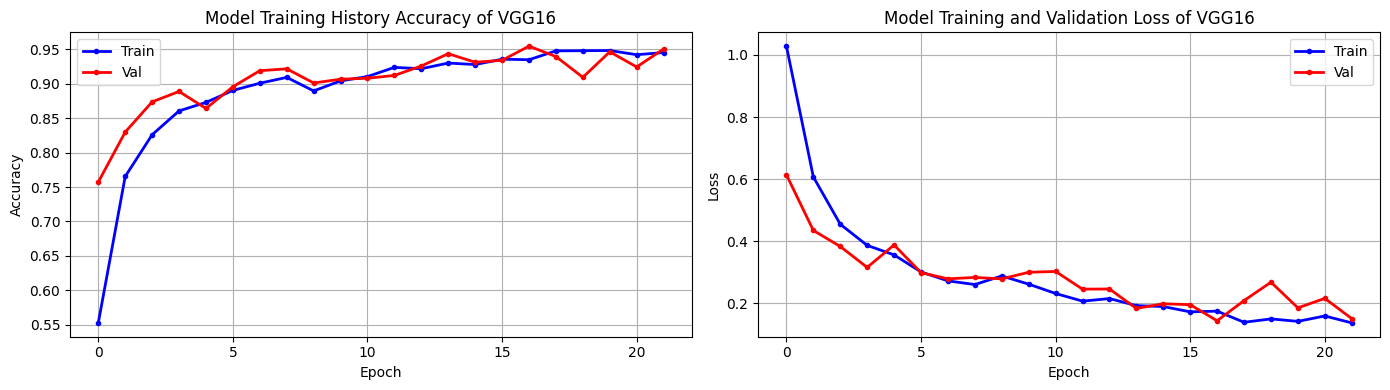

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))


# Plot Categorical Accuracy and Validation Accuracy
axes[0].grid(True)
axes[0].plot(train_history_vgg.history['categorical_accuracy'], '.b-', linewidth=2, label='Categorical Accuracy')
axes[0].plot(train_history_vgg.history['val_categorical_accuracy'], '.r-', linewidth=2, label='Validation Accuracy')
axes[0].set_title('Model Training History Accuracy of VGG16')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(0,len(train_history_vgg.history['categorical_accuracy']),5))
#axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[0].legend(['Train','Val'])


# Plot Training Loss and Validation Loss

#if 'val_loss' in train_history_ResNet50.history:
axes[1].grid(True)
axes[1].plot(train_history_vgg.history['loss'], '.b-', label='Training Loss', linewidth=2)
axes[1].plot(train_history_vgg.history['val_loss'], '.r-', label='Validation Loss', linewidth=2)


axes[1].set_title('Model Training and Validation Loss of VGG16')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(range(0,len(train_history_vgg.history['loss']),5))


#axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1].legend(['Train','Val'])


plt.tight_layout()
plt.show()

In [ ]:
test_epoch = '15'
weights_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/vgg/epocch_"+test_epoch+".hdf5"
model_vgg.load_weights(weights_path)

In [ ]:
# Evaluate the model on the test set for VGG16
evaluation_results_vgg = model_vgg.evaluate(test_dataset)

# Print the evaluation results
print(f'Test Loss: {evaluation_results_vgg[0]}')
print(f'Test Accuracy: {evaluation_results_vgg[1]}')

21/21 [==============================] - 431s 22s/step - loss: 0.2242 - categorical_accuracy: 0.9239
Test Loss: 0.22423599660396576
Test Accuracy: 0.9239373803138733


In [ ]:
y_perd_vgg = model_vgg.predict(test_dataset)

21/21 [==============================] - 6s 278ms/step


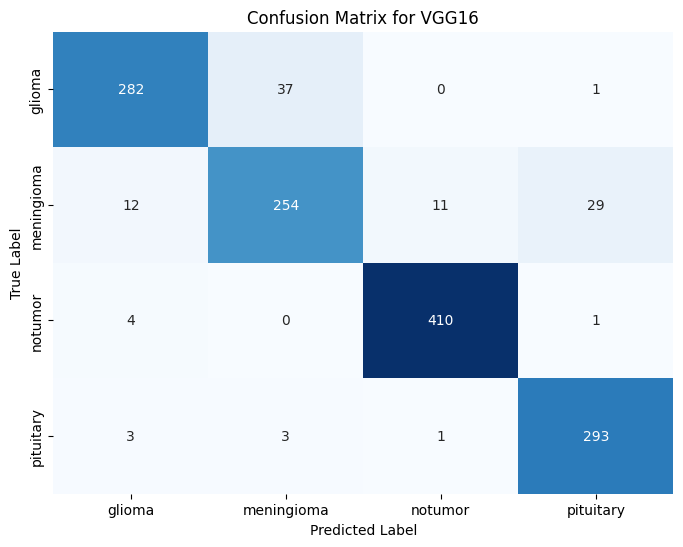

In [ ]:
unique_labels = ['glioma','meningioma','notumor','pituitary']

# confusion_matrix for VGG16
conf_matrix = confusion_matrix(test_dataset.labels,np.argmax(y_perd_vgg,axis=-1))
conf_matrix_data = np.array(conf_matrix)


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for VGG16')
plt.show()

In [ ]:
print(classification_report(test_dataset.labels,np.argmax(y_perd_vgg,axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       320
           1       0.86      0.83      0.85       306
           2       0.97      0.99      0.98       415
           3       0.90      0.98      0.94       300

    accuracy                           0.92      1341
   macro avg       0.92      0.92      0.92      1341
weighted avg       0.92      0.92      0.92      1341



# **Xception Model**

In [ ]:
model_xception =  model_def(Xception(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_xception.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_2 (Dropout)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                       

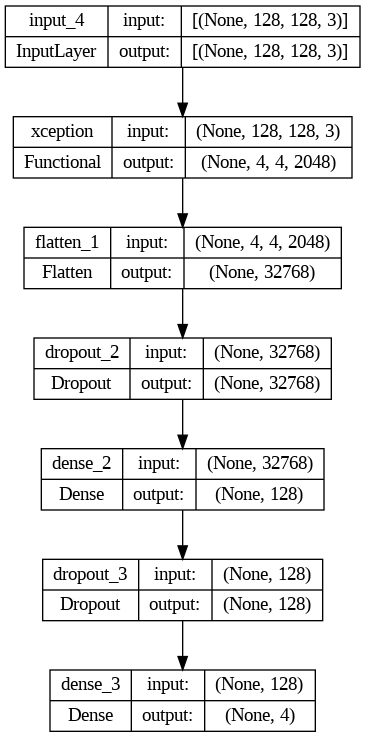

In [ ]:
keras.utils.plot_model(model_xception, show_shapes=True)

In [ ]:
model_xception.compile(optimizer=Adam(learning_rate = 0.0001),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [ ]:
ckp_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size)) # x * epocs
ckp_folder = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/xception"
ckp_path = os.path.join(ckp_folder,r"epocch_{epoch:02d}.hdf5")

model_xception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    #mode='max',
    verbose=1,
    save_freq= ckp_interval
    #save_best_only=True
)

In [ ]:
%%time
train_history_xception = model_xception.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 30,
                          callbacks = [early_stopping, model_xception_checkpoint_callback])
# Save the train history
with open(os.path.join(ckp_folder,'train_history_xception'), 'wb') as file_pi:
    pickle.dump(train_history_xception, file_pi)

Epoch 1/30
65/65 [==============================] - 58s 784ms/step - loss: 0.6604 - categorical_accuracy: 0.7450 - val_loss: 0.4785 - val_categorical_accuracy: 0.8080
Epoch 2/30
65/65 [==============================] - 42s 645ms/step - loss: 0.4291 - categorical_accuracy: 0.8330 - val_loss: 0.4431 - val_categorical_accuracy: 0.8272
Epoch 3/30
65/65 [==============================] - 42s 644ms/step - loss: 0.3677 - categorical_accuracy: 0.8614 - val_loss: 0.3923 - val_categorical_accuracy: 0.8628
Epoch 4/30
65/65 [==============================] - 41s 632ms/step - loss: 0.3217 - categorical_accuracy: 0.8788 - val_loss: 0.3557 - val_categorical_accuracy: 0.8669
Epoch 5/30
64/65 [============================>.] - ETA: 0s - loss: 0.3115 - categorical_accuracy: 0.8816
Epoch 5: saving model to drive/MyDrive/Tumor_Classification/Model-Checkpoints/vgg/epocch_05.hdf5
65/65 [==============================] - 43s 661ms/step - loss: 0.3092 - categorical_accuracy: 0.8825 - val_loss: 0.3466 - val_ca

In [ ]:
model_xception.save('/content/drive/MyDrive/ModelSave/Xception/xception.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print(train_history_xception.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [ ]:
# If load the history from the previsouly trained model.
with open(os.path.join(ckp_folder,'train_history_xception'), 'rb') as file_pi:
    train_history_xception = pickle.load(file_pi)

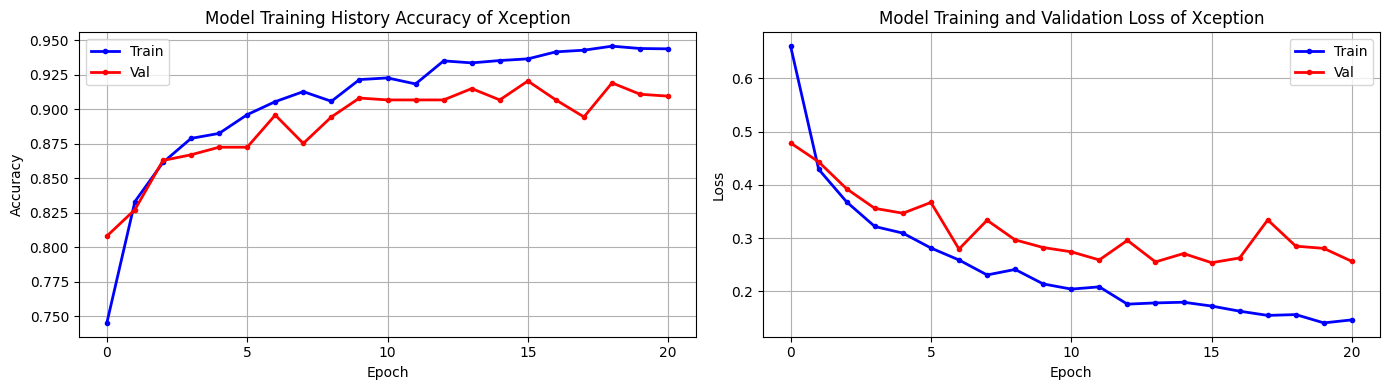

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))


# Plot Categorical Accuracy and Validation Accuracy
axes[0].grid(True)
axes[0].plot(train_history_xception.history['categorical_accuracy'], '.b-', linewidth=2, label='Categorical Accuracy')
axes[0].plot(train_history_xception.history['val_categorical_accuracy'], '.r-', linewidth=2, label='Validation Accuracy')
axes[0].set_title('Model Training History Accuracy of Xception')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(0,len(train_history_xception.history['categorical_accuracy']),5))
#axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[0].legend(['Train','Val'])


# Plot Training Loss and Validation Loss

axes[1].grid(True)
axes[1].plot(train_history_xception.history['loss'], '.b-', label='Training Loss', linewidth=2)
axes[1].plot(train_history_xception.history['val_loss'], '.r-', label='Validation Loss', linewidth=2)


axes[1].set_title('Model Training and Validation Loss of Xception')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(range(0,len(train_history_xception.history['loss']),5))


#axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1].legend(['Train','Val'])


plt.tight_layout()
plt.show()

In [ ]:
test_epoch = '30'
weights_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/xception/epocch_"+test_epoch+".hdf5"
model_xception.load_weights(weights_path)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'drive/MyDrive/Tumor_Classification/Model-Checkpoints/xception/epocch_30.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Evaluate the model on the test set
evaluation_results_xception = model_xception.evaluate(test_dataset)

# Print the evaluation results
print(f'Test Loss: {evaluation_results_xception[0]}')
print(f'Test Accuracy: {evaluation_results_xception[1]}')

21/21 [==============================] - 10s 457ms/step - loss: 0.2855 - categorical_accuracy: 0.8971
Test Loss: 0.28550517559051514
Test Accuracy: 0.8970917463302612


In [ ]:
y_perd_xception = model_xception.predict(test_dataset)

21/21 [==============================] - 8s 331ms/step


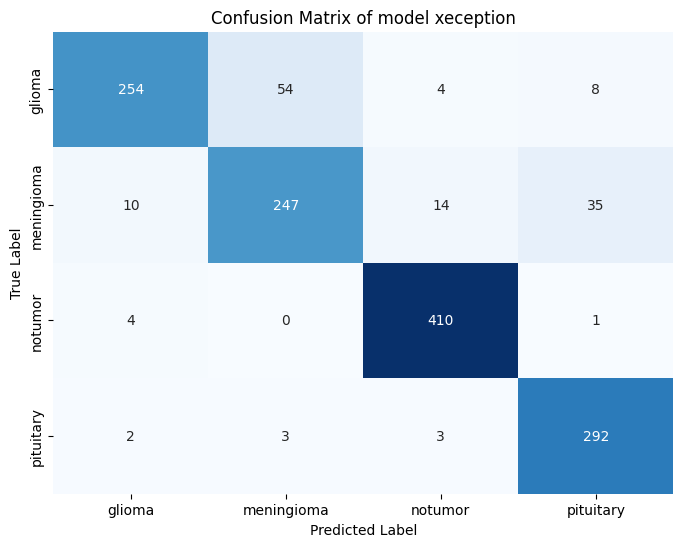

In [ ]:
unique_labels = ['glioma','meningioma','notumor','pituitary']

# confusion_matrix
conf_matrix = confusion_matrix(test_dataset.labels,np.argmax(y_perd_xception,axis=-1))
conf_matrix_data = np.array(conf_matrix)


# Plotting the confusion matrix of xception
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of model xeception')
plt.show()

In [ ]:
print(classification_report(test_dataset.labels,np.argmax(y_perd_xception,axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       320
           1       0.81      0.81      0.81       306
           2       0.95      0.99      0.97       415
           3       0.87      0.97      0.92       300

    accuracy                           0.90      1341
   macro avg       0.89      0.89      0.89      1341
weighted avg       0.90      0.90      0.90      1341



# **MobileNet Model**

In [ ]:
model_MobileNet =  model_def(MobileNet(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_MobileNet.summary()

17225924/17225924 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dropout (Dropout)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 128)               2097280   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 51

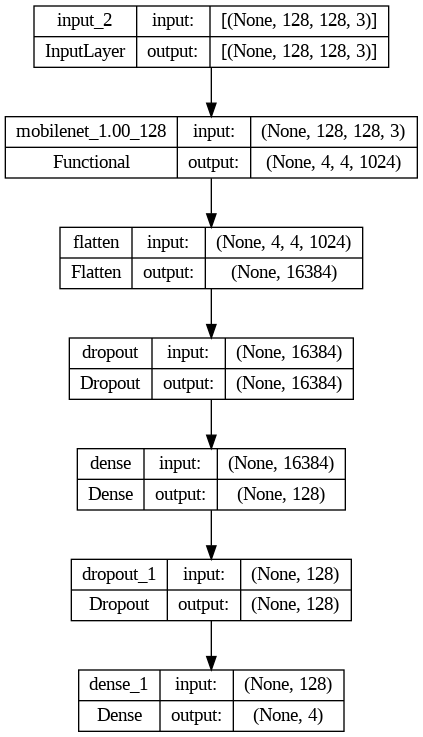

In [ ]:
keras.utils.plot_model(model_MobileNet, show_shapes=True)

In [ ]:
model_MobileNet.compile(optimizer=Adam(learning_rate=0.00001),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [ ]:
ckp_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size)) # x * epocs
ckp_folder = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/MobileNet"
ckp_path = os.path.join(ckp_folder,r"epocch_{epoch:02d}.hdf5")

model_MobileNet_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    #mode='max',
    verbose=1,
    save_freq= ckp_interval
    #save_best_only=True
)

In [ ]:
%%time
train_history_MobileNet = model_MobileNet.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 50,
                          callbacks = [early_stopping, model_MobileNet_checkpoint_callback])

# Save the train history
with open(os.path.join(ckp_folder,'train_history_MobileNet'), 'wb') as file_pi:
    pickle.dump(train_history_MobileNet, file_pi)

Epoch 1/50
65/65 [==============================] - 3200s 49s/step - loss: 1.3861 - categorical_accuracy: 0.5332 - val_loss: 0.6808 - val_categorical_accuracy: 0.7202
Epoch 2/50
65/65 [==============================] - 42s 653ms/step - loss: 0.8923 - categorical_accuracy: 0.6825 - val_loss: 0.5120 - val_categorical_accuracy: 0.7901
Epoch 3/50
65/65 [==============================] - 42s 648ms/step - loss: 0.7164 - categorical_accuracy: 0.7370 - val_loss: 0.4581 - val_categorical_accuracy: 0.8176
Epoch 4/50
65/65 [==============================] - 43s 667ms/step - loss: 0.6181 - categorical_accuracy: 0.7698 - val_loss: 0.4364 - val_categorical_accuracy: 0.8299
Epoch 5/50
64/65 [============================>.] - ETA: 0s - loss: 0.5755 - categorical_accuracy: 0.7903
Epoch 5: saving model to drive/MyDrive/Tumor_Classification/Model-Checkpoints/MobileNet/epocch_05.hdf5
65/65 [==============================] - 44s 672ms/step - loss: 0.5743 - categorical_accuracy: 0.7901 - val_loss: 0.4089 - 

In [ ]:
model_MobileNet.save('/content/drive/MyDrive/ModelSave/MobileNet/MobileNet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print(train_history_MobileNet.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [ ]:
# If load the history from the previsouly trained model.
with open(os.path.join(ckp_folder,'train_history_MobileNet'), 'rb') as file_pi:
    train_history_MobileNet = pickle.load(file_pi)

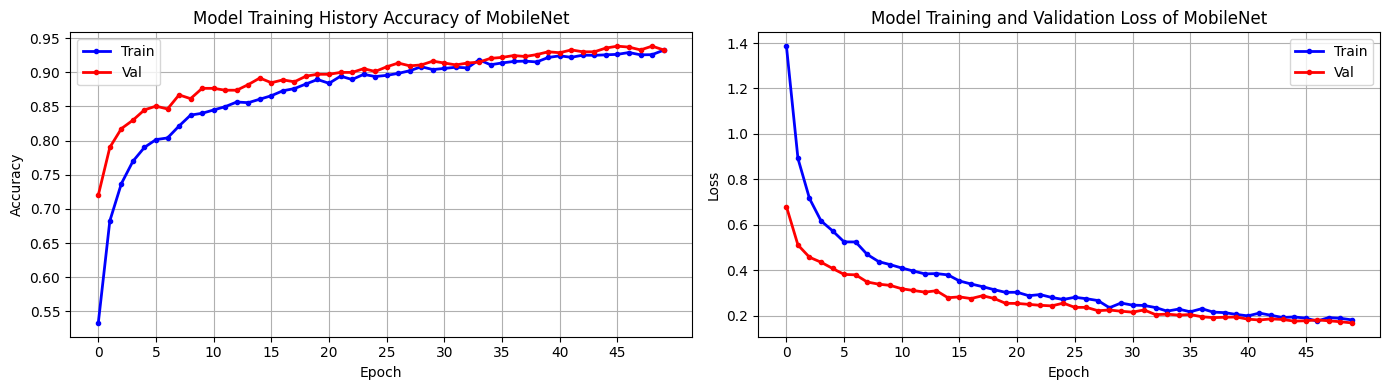

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Plot Categorical Accuracy and Validation Accuracy
axes[0].plot(train_history_MobileNet.history['categorical_accuracy'], '.b-', linewidth=2, label='Categorical Accuracy')
axes[0].plot(train_history_MobileNet.history['val_categorical_accuracy'], '.r-', linewidth=2, label='Validation Accuracy')
axes[0].set_title('Model Training History Accuracy of MobileNet')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(0, len(train_history_MobileNet.history['categorical_accuracy']), 5))
axes[0].legend(['Train', 'Val'])

# Plot Training Loss and Validation Loss
axes[1].plot(train_history_MobileNet.history['loss'], '.b-', label='Training Loss', linewidth=2)
axes[1].plot(train_history_MobileNet.history['val_loss'], '.r-', label='Validation Loss', linewidth=2)

axes[1].set_title('Model Training and Validation Loss of MobileNet')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(range(0, len(train_history_MobileNet.history['loss']), 5))
axes[1].legend(['Train', 'Val'])

# Remove grid lines
axes[0].grid(True)
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
test_epoch = '50'
weights_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/MobileNet/epocch_"+test_epoch+".hdf5"
model_MobileNet.load_weights(weights_path)

In [ ]:
# Evaluate the model on the test set
evaluation_results_MobileNet = model_MobileNet.evaluate(test_dataset)

# Print the evaluation results
print(f'Test Loss: {evaluation_results_MobileNet[0]}')
print(f'Test Accuracy: {evaluation_results_MobileNet[1]}')

21/21 [==============================] - 907s 45s/step - loss: 0.2209 - categorical_accuracy: 0.9165
Test Loss: 0.22090907394886017
Test Accuracy: 0.9164802432060242


In [ ]:
y_perd_MobileNet = model_MobileNet.predict(test_dataset)

21/21 [==============================] - 7s 284ms/step


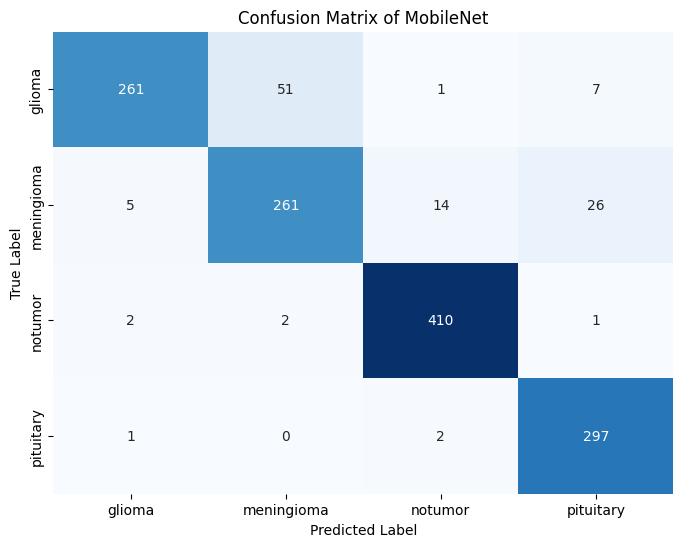

In [ ]:
unique_labels = ['glioma','meningioma','notumor','pituitary']

# confusion_matrix of MobileNet
conf_matrix = confusion_matrix(test_dataset.labels,np.argmax(y_perd_MobileNet,axis=-1))
conf_matrix_data = np.array(conf_matrix)


# Plotting the confusion matrix of MobileNet
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of MobileNet')
plt.show()

In [ ]:
print(classification_report(test_dataset.labels,np.argmax(y_perd_MobileNet,axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89       320
           1       0.83      0.85      0.84       306
           2       0.96      0.99      0.97       415
           3       0.90      0.99      0.94       300

    accuracy                           0.92      1341
   macro avg       0.91      0.91      0.91      1341
weighted avg       0.92      0.92      0.92      1341



# **ResNet50 Model**

In [ ]:
model_ResNet50 =  model_def(ResNet50(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_ResNet50.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_2 (Dropout)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                       

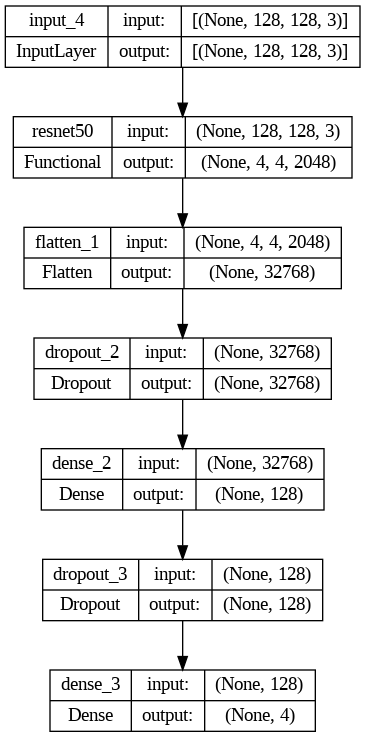

In [ ]:
keras.utils.plot_model(model_ResNet50, show_shapes=True)

In [ ]:
model_ResNet50.compile(optimizer=Adam(learning_rate=0.00005),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [ ]:
ckp_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size)) # x * epocs
ckp_folder = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/ResNet50"
ckp_path = os.path.join(ckp_folder,r"epocch_{epoch:02d}.hdf5")

model_ResNet50_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    #mode='max',
    verbose=1,
    save_freq= ckp_interval
    #save_best_only=True
)

In [ ]:
%%time
train_history_ResNet50 = model_ResNet50.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 50,
                          callbacks = [model_ResNet50_checkpoint_callback])


# Save the train history
with open(os.path.join(ckp_folder,'train_history_ResNet50'), 'wb') as file_pi:
    pickle.dump(train_history_ResNet50, file_pi)

Epoch 1/50
65/65 [==============================] - 51s 697ms/step - loss: 1.2375 - categorical_accuracy: 0.4370 - val_loss: 1.5098 - val_categorical_accuracy: 0.2318
Epoch 2/50
65/65 [==============================] - 44s 670ms/step - loss: 1.0544 - categorical_accuracy: 0.5359 - val_loss: 1.3981 - val_categorical_accuracy: 0.2373
Epoch 3/50
65/65 [==============================] - 42s 651ms/step - loss: 0.9644 - categorical_accuracy: 0.5795 - val_loss: 1.3057 - val_categorical_accuracy: 0.2743
Epoch 4/50
65/65 [==============================] - 42s 651ms/step - loss: 0.9220 - categorical_accuracy: 0.5969 - val_loss: 1.1308 - val_categorical_accuracy: 0.4623
Epoch 5/50
64/65 [============================>.] - ETA: 0s - loss: 0.8973 - categorical_accuracy: 0.6184
Epoch 5: saving model to drive/MyDrive/Tumor_Classification/Model-Checkpoints/ResNet50/epocch_05.hdf5
65/65 [==============================] - 44s 673ms/step - loss: 0.8952 - categorical_accuracy: 0.6200 - val_loss: 0.9054 - v

In [ ]:
model_ResNet50.save('/content/drive/MyDrive/ModelSave/ResNet50/ResNet50.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print(train_history_ResNet50.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [ ]:
# If load the history from the previsouly trained model.
with open(os.path.join(ckp_folder,'train_history_ResNet50'), 'rb') as file_pi:
    train_history_ResNet50 = pickle.load(file_pi)

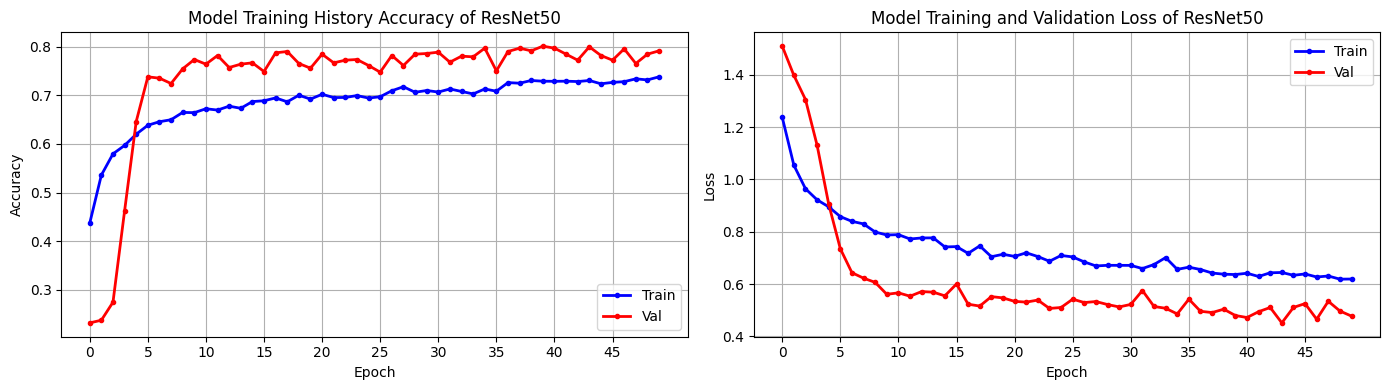

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Plot Categorical Accuracy and Validation Accuracy
axes[0].grid(True)
axes[0].plot(train_history_ResNet50.history['categorical_accuracy'], '.b-', linewidth=2, label='Categorical Accuracy')
axes[0].plot(train_history_ResNet50.history['val_categorical_accuracy'], '.r-', linewidth=2, label='Validation Accuracy')
axes[0].set_title('Model Training History Accuracy of ResNet50')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(0,len(train_history_ResNet50.history['categorical_accuracy']),5))
#axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[0].legend(['Train','Val'])

# Plot Training Loss and Validation Loss


#if 'val_loss' in train_history_ResNet50.history:
axes[1].grid(True)
axes[1].plot(train_history_ResNet50.history['loss'], '.b-', label='Training Loss', linewidth=2)
axes[1].plot(train_history_ResNet50.history['val_loss'], '.r-', label='Validation Loss', linewidth=2)

axes[1].set_title('Model Training and Validation Loss of ResNet50')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(range(0,len(train_history_ResNet50.history['loss']),5))

#axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1].legend(['Train','Val'])


plt.tight_layout()
plt.show()


In [ ]:
test_epoch = '45'
weights_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/ResNet50/epocch_"+test_epoch+".hdf5"
model_ResNet50.load_weights(weights_path)

In [ ]:
# Evaluate the model on the test set
evaluation_results_ResNet50 = model_ResNet50.evaluate(test_dataset)

# Print the evaluation results
print(f'Test Loss: {evaluation_results_ResNet50[0]}')
print(f'Test Accuracy: {evaluation_results_ResNet50[1]}')

21/21 [==============================] - 7s 350ms/step - loss: 0.5650 - categorical_accuracy: 0.7666
Test Loss: 0.5649574995040894
Test Accuracy: 0.7665920853614807


In [ ]:
y_perd_ResNet50 = model_ResNet50.predict(test_dataset)

21/21 [==============================] - 7s 262ms/step


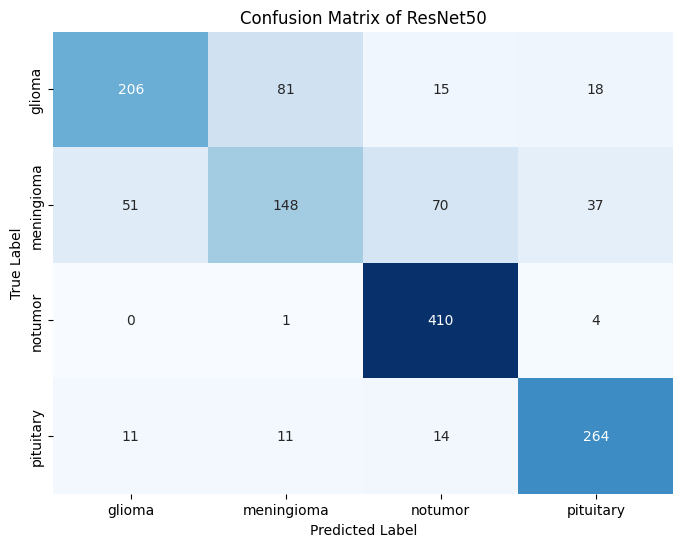

In [ ]:
unique_labels = ['glioma','meningioma','notumor','pituitary']

# confusion_matrix of ResNet50
conf_matrix = confusion_matrix(test_dataset.labels,np.argmax(y_perd_ResNet50,axis=-1))
conf_matrix_data = np.array(conf_matrix)


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of ResNet50')
plt.show()

In [ ]:
print(classification_report(test_dataset.labels,np.argmax(y_perd_ResNet50,axis=1)))

              precision    recall  f1-score   support

           0       0.77      0.64      0.70       320
           1       0.61      0.48      0.54       306
           2       0.81      0.99      0.89       415
           3       0.82      0.88      0.85       300

    accuracy                           0.77      1341
   macro avg       0.75      0.75      0.74      1341
weighted avg       0.76      0.77      0.75      1341



# **VGG19 Model**

In [ ]:
model_vgg19 =  model_def(VGG19(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_vgg19.summary()

80134624/80134624 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                       

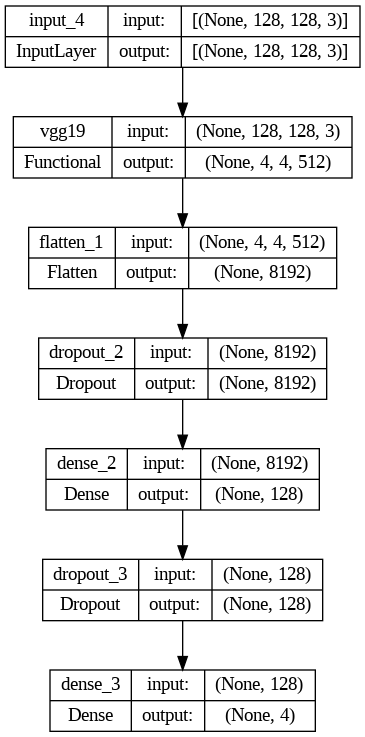

In [ ]:
keras.utils.plot_model(model_vgg19, show_shapes=True)

In [ ]:
model_vgg19.compile(optimizer=Adam(learning_rate=0.00001),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [ ]:
ckp_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size)) # x * epocs
ckp_folder = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/vgg19"
ckp_path = os.path.join(ckp_folder,r"epocch_{epoch:02d}.hdf5")

model_vgg19_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    #mode='max',
    verbose=1,
    save_freq= ckp_interval
    #save_best_only=True
)

In [ ]:
%%time
train_history_vgg19 = model_vgg19.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 30,
                          callbacks = [model_vgg19_checkpoint_callback])


# Save the train history
with open(os.path.join(ckp_folder,'train_history_vgg19'), 'wb') as file_pi:
    pickle.dump(train_history_vgg19, file_pi)

Epoch 1/30
65/65 [==============================] - 3620s 56s/step - loss: 1.1946 - categorical_accuracy: 0.4607 - val_loss: 0.7811 - val_categorical_accuracy: 0.6516
Epoch 2/30
65/65 [==============================] - 46s 710ms/step - loss: 0.8209 - categorical_accuracy: 0.6587 - val_loss: 0.6275 - val_categorical_accuracy: 0.7366
Epoch 3/30
65/65 [==============================] - 46s 712ms/step - loss: 0.7105 - categorical_accuracy: 0.7082 - val_loss: 0.5283 - val_categorical_accuracy: 0.7929
Epoch 4/30
65/65 [==============================] - 45s 684ms/step - loss: 0.6256 - categorical_accuracy: 0.7538 - val_loss: 0.4852 - val_categorical_accuracy: 0.8052
Epoch 5/30
64/65 [============================>.] - ETA: 0s - loss: 0.5647 - categorical_accuracy: 0.7774
Epoch 5: saving model to drive/MyDrive/Tumor_Classification/Model-Checkpoints/vgg19/epocch_05.hdf5
65/65 [==============================] - 46s 702ms/step - loss: 0.5633 - categorical_accuracy: 0.7778 - val_loss: 0.4566 - val_

In [ ]:
model_vgg19.save('/content/drive/MyDrive/ModelSave/vgg19/vgg19.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print(train_history_vgg19.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [ ]:
# If load the history from the previsouly trained model.
with open(os.path.join(ckp_folder,'train_history_vgg19'), 'rb') as file_pi:
    train_history_vgg19 = pickle.load(file_pi)

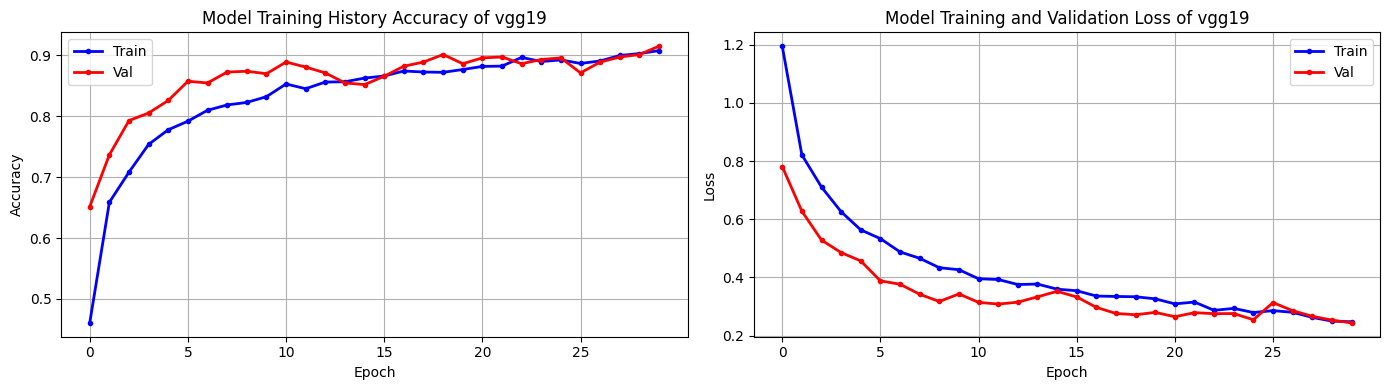

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Plot Categorical Accuracy and Validation Accuracy
axes[0].grid(True)
axes[0].plot(train_history_vgg19.history['categorical_accuracy'], '.b-', linewidth=2, label='Categorical Accuracy')
axes[0].plot(train_history_vgg19.history['val_categorical_accuracy'], '.r-', linewidth=2, label='Validation Accuracy')
axes[0].set_title('Model Training History Accuracy of vgg19')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(0,len(train_history_vgg19.history['categorical_accuracy']),5))
#axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[0].legend(['Train','Val'])

# Plot Training Loss and Validation Loss


#if 'val_loss' in train_history_vgg19.history:
axes[1].grid(True)
axes[1].plot(train_history_vgg19.history['loss'], '.b-', label='Training Loss', linewidth=2)
axes[1].plot(train_history_vgg19.history['val_loss'], '.r-', label='Validation Loss', linewidth=2)

axes[1].set_title('Model Training and Validation Loss of vgg19')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(range(0,len(train_history_vgg19.history['loss']),5))

#axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1].legend(['Train','Val'])


plt.tight_layout()
plt.show()


In [ ]:
test_epoch = '30'
weights_path = r"drive/MyDrive/Tumor_Classification/Model-Checkpoints/vgg19/epocch_"+test_epoch+".hdf5"
model_vgg19.load_weights(weights_path)

In [ ]:
# Evaluate the model on the test set
evaluation_results_vgg19 = model_vgg19.evaluate(test_dataset)

# Print the evaluation results
print(f'Test Loss: {evaluation_results_vgg19[0]}')
print(f'Test Accuracy: {evaluation_results_vgg19[1]}')

21/21 [==============================] - 998s 50s/step - loss: 0.3067 - categorical_accuracy: 0.8917
Test Loss: 0.3067365884780884
Test Accuracy: 0.8916857242584229


In [ ]:
y_perd_vgg19 = model_vgg19.predict(test_dataset)

21/21 [==============================] - 7s 303ms/step


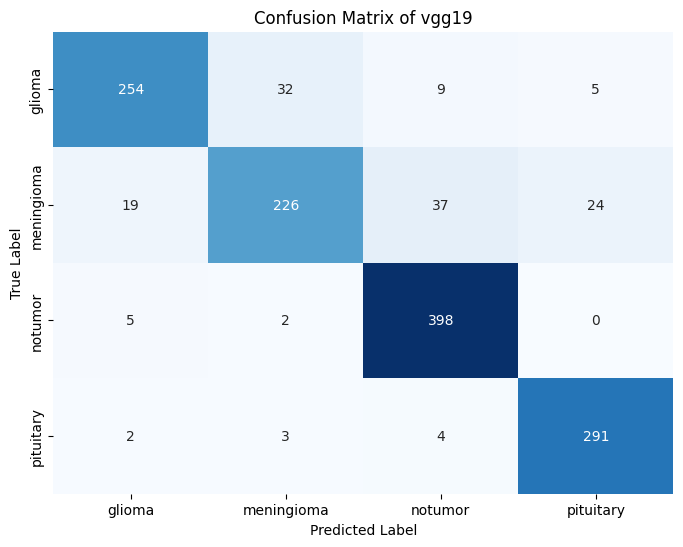

In [ ]:
unique_labels = ['glioma','meningioma','notumor','pituitary']

# confusion_matrix of InceptionV3
conf_matrix = confusion_matrix(test_dataset.labels,np.argmax(y_perd_vgg19,axis=-1))
conf_matrix_data = np.array(conf_matrix)


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of vgg19')
plt.show()

In [ ]:
print(classification_report(test_dataset.labels,np.argmax(y_perd_vgg19,axis=1)))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       300
           1       0.86      0.74      0.79       306
           2       0.89      0.98      0.93       405
           3       0.91      0.97      0.94       300

    accuracy                           0.89      1311
   macro avg       0.89      0.88      0.89      1311
weighted avg       0.89      0.89      0.89      1311

